# Peak detection algorithm

This notebook is designed to provide a simple step-by-step guide on finding peaks using a window-propagation method with a second-derivative sign-values.

In [1]:
import numpy as np
import scipy.signal as signal
from scipy.interpolate import UnivariateSpline # this is for interpolation
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

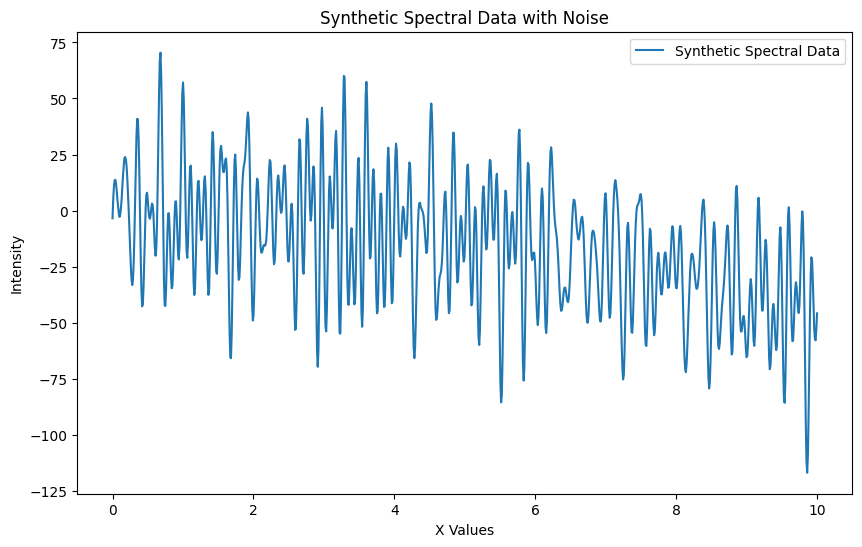

In [2]:
# we need some fake signals
def generate_fake_spectral_data(length=1000, num_peaks=10, noise_level=0.2, poly_degree=2):
    x = np.linspace(0, 10, length)
    spectral_data = np.zeros(length)

    # Generate multiple sinusoidal peaks
    for _ in range(num_peaks):
        amplitude = np.random.uniform(1, 20)  # Varying amplitude of peaks
        frequency = np.random.uniform(0.5, 10)  # Varying frequency of peaks
        phase = np.random.uniform(0, 2 * np.pi)  # Random phase shift for each peak
        peak = amplitude * np.sin(2 * np.pi * frequency * x + phase)
        spectral_data += peak

    # Add a polynomial component
    poly_coefficients = np.random.uniform(-1, 1, poly_degree + 1)  # Random coefficients for the polynomial
    polynomial = np.polyval(poly_coefficients, x)
    spectral_data += polynomial

    # Add noise to the data
    spectral_data_with_noise = spectral_data + noise_level * np.random.randn(length)

    return x, spectral_data_with_noise

# Generate synthetic spectral data
x_values, synthetic_spectral_data = generate_fake_spectral_data()

# Plotting the generated synthetic spectral data
plt.figure(figsize=(10, 6))
plt.plot(x_values, synthetic_spectral_data, label='Synthetic Spectral Data')
plt.title('Synthetic Spectral Data with Noise')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

We first need to interpolate the given data to obtain the derivatives of the data.

This interpolation scheme will allow the user to choose "how fine" their data is. If the input data is too sparse, one can interpolate the signal to make the input richer.

In [3]:
class Interpolate():
    def __init__(self,
                 input_x,
                 input_y,
                 degree_spline=3,
                 gratings=1000):
        """_summary_

        Args:
            input_x (1D np array): array of the x-variables
            input_y (1D np array): array of the y-variables
            degree_spline (int, optional): _description_. Defaults to 3.
            gratings (int, optional): _description_. Defaults to 1000.
        """
        self.y_spline = None

        self.domain_size = int(gratings)

        self.x_val = None
        self.y_val = None

        # degree of the smoothing spline
        self.k = degree_spline
        if self.k > 5:
            self.k = 5
        elif self.k < 1:
            self.k = 1

        self.first_deriv = None
        self.second_deriv = None

        if np.max(input_y) > 1:
            input_y = input_y / np.max(input_y)

        self.interpolate(input_x, input_y)

    def interpolate(self, x_in, y_in):
        self.y_spline = UnivariateSpline(x_in, y_in, s=0, k=self.k)
        self.x_val = np.linspace(x_in[0],
                                  x_in[-1],
                                  self.domain_size)
        self.y_val = self.y_spline(self.x_val)

        self.first_deriv = self.y_spline.derivative(n=1)(self.x_val)
        self.second_deriv = self.y_spline.derivative(n=2)(self.x_val)
        self.second_deriv = self.second_deriv/np.max(self.second_deriv)

In [4]:
interpolated = Interpolate(x_values, synthetic_spectral_data)

Now what we need is to denoise the signal using the Savitzky-Golay filter.

In [5]:
def denoise_signal(y, window_length=31, order=3):
    denoised_y = savgol_filter(y, window_length=window_length, polyorder=order)
    return denoised_y

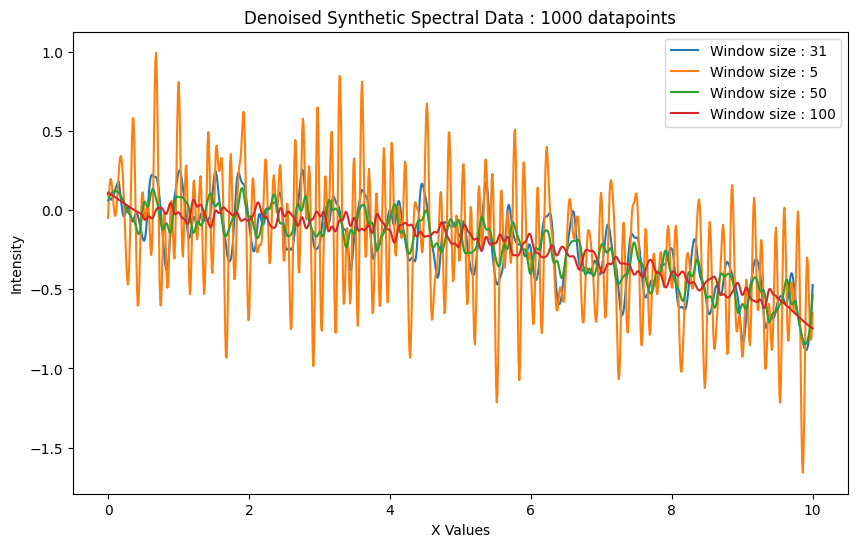

In [6]:
denoised_y_wl31 = denoise_signal(interpolated.y_val)
denoised_y_wl05 = denoise_signal(interpolated.y_val, window_length=5)
denoised_y_wl50 = denoise_signal(interpolated.y_val, window_length=50)
denoised_y_wl100= denoise_signal(interpolated.y_val, window_length=100)

# Plotting the generated synthetic spectral data
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, denoised_y_wl31, label='Window size : 31')
plt.plot(interpolated.x_val, denoised_y_wl05, label='Window size : 5')
plt.plot(interpolated.x_val, denoised_y_wl50, label='Window size : 50')
plt.plot(interpolated.x_val, denoised_y_wl100, label='Window size : 100')
plt.title('Denoised Synthetic Spectral Data : 1000 datapoints')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

Note that if we had sparser datapoints, the larger window-sizes may eliminate the peaks we wanted.

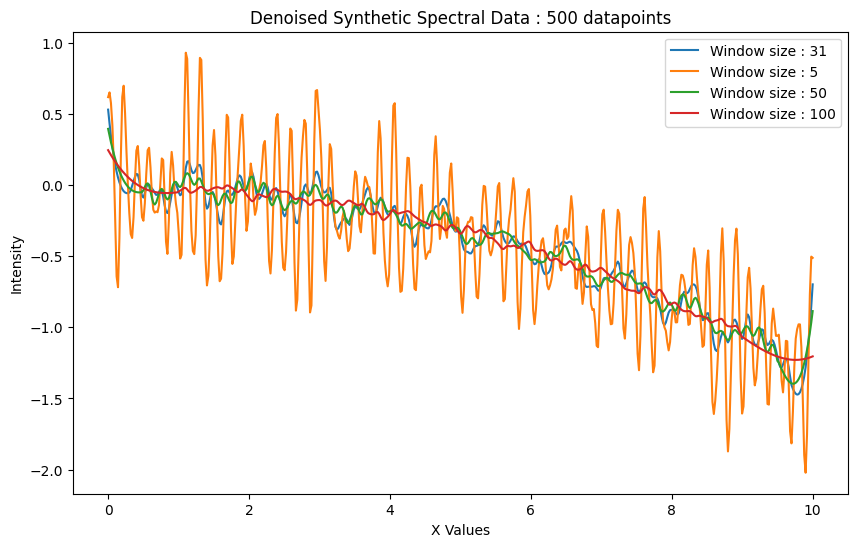

In [27]:
interpolated_sparse = Interpolate(x_values, synthetic_spectral_data, gratings=500)

sparse_denoised_y_wl31 = denoise_signal(interpolated_sparse.y_val)
sparse_denoised_y_wl05 = denoise_signal(interpolated_sparse.y_val, window_length=5)
sparse_denoised_y_wl50 = denoise_signal(interpolated_sparse.y_val, window_length=50)
sparse_denoised_y_wl100= denoise_signal(interpolated_sparse.y_val, window_length=100)

# Plotting the generated synthetic spectral data
plt.figure(figsize=(10, 6))
plt.plot(interpolated_sparse.x_val, sparse_denoised_y_wl31, label='Window size : 31')
plt.plot(interpolated_sparse.x_val, sparse_denoised_y_wl05, label='Window size : 5')
plt.plot(interpolated_sparse.x_val, sparse_denoised_y_wl50, label='Window size : 50')
plt.plot(interpolated_sparse.x_val, sparse_denoised_y_wl100, label='Window size : 100')
plt.title('Denoised Synthetic Spectral Data : 500 datapoints')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Re-make the `Interpolate` class to include the denoising function

Note that different gratings and window-sizes above will produce different kind of signal output. Some results may contain too little or too much information. This means, the user need to tune the parameters according to the result (s)he's getting. If the `Interpolate` class has both functionalities, the user will only have to deal with this class to tune the parameters.

In [8]:
class Interpolate():
    def __init__(self,
                 input_x,
                 input_y,
                 degree_spline=3,
                 gratings=1000,
                 denoising_window_size=30,
                 denoising_order=3):
        """_summary_

        Args:
            input_x (1D np array): array of the x-variables
            input_y (1D np array): array of the y-variables
            degree_spline (int, optional): degree of spline interpolation. Defaults to 3.
            gratings (int, optional): number of datapoints obtained by the interpolation. Defaults to 1000.
            denoising_window_size (int, optional) : size of the window used to denoise the interpolated signal. Defaults to 30
            denoising_order (int, optional) : order of the polynomial for the Savitzky-Golay filter.Defaults to 3
        """
        self.y_spline = None

        self.domain_size = int(gratings)
        self.denoising_window = denoising_window_size
        self.denoising_order  = denoising_order

        self.x_val = None
        self.y_val = None

        # degree of the smoothing spline
        self.k = degree_spline
        if self.k > 5:
            self.k = 5
        elif self.k < 1:
            self.k = 1

        self.first_deriv = None
        self.second_deriv = None

        if np.max(input_y) > 1:
            input_y = input_y / np.max(input_y)

        self.interpolate(input_x, input_y)

    def interpolate(self, x_in, y_in):
        self.y_spline = UnivariateSpline(x_in, y_in, s=0, k=self.k)
        self.x_val = np.linspace(x_in[0],
                                  x_in[-1],
                                  self.domain_size)
        self.y_val = self.y_spline(self.x_val)

        self.first_deriv = self.y_spline.derivative(n=1)(self.x_val)
        self.second_deriv = self.y_spline.derivative(n=2)(self.x_val)
        self.second_deriv = self.second_deriv/np.max(self.second_deriv)
        
    def denoise_signal(self):
        denoised_y = savgol_filter(self.y_val, window_length=self.denoising_window, polyorder=self.denoising_order)
        self.interpolate(self.x_val, denoised_y)

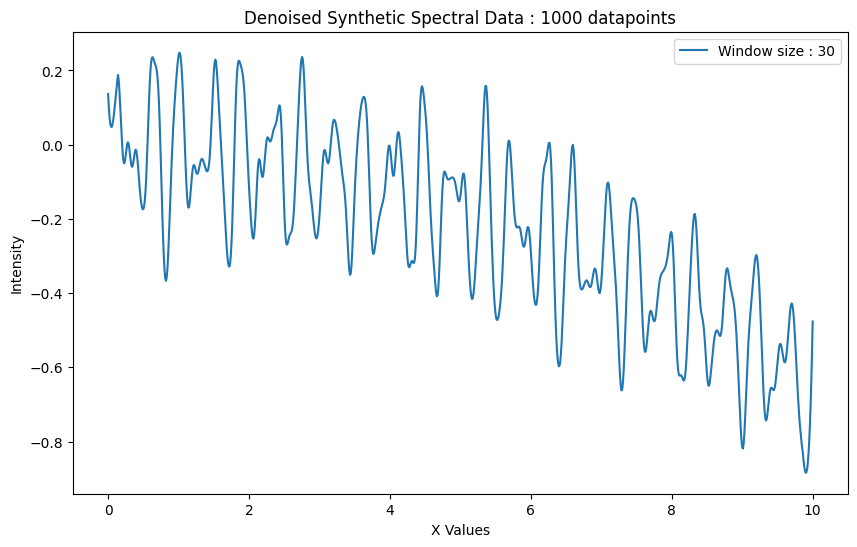

In [9]:
interpolated = Interpolate(x_values, synthetic_spectral_data)
interpolated.denoise_signal() # denoise the signal from the given parameters

# Plotting the generated synthetic spectral data
plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, label='Window size : 30')
plt.title('Denoised Synthetic Spectral Data : 1000 datapoints')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [10]:
def find_peaks(class_interpolate, window_size=10, threshold=0.01):
        peaks = []
                
        for i in range(window_size, len(class_interpolate.second_deriv) - window_size):
            window_second_deriv = class_interpolate.second_deriv[i - window_size:i + window_size + 1]
            window              = class_interpolate.y_val[i - window_size:i + window_size + 1]
            
            # Check if the central point is the maximum within its window
            if class_interpolate.second_deriv[i] == np.min(window_second_deriv) and class_interpolate.y_val[i] > np.max(window)-threshold:
                peaks.append(i)
        
        return peaks

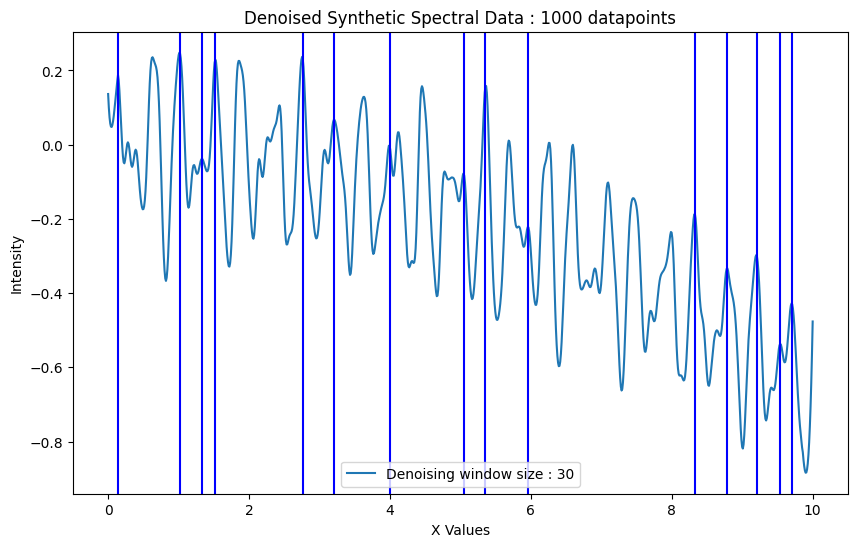

In [13]:
peaks = find_peaks(interpolated, window_size=10)


plt.figure(figsize=(10, 6))
plt.plot(interpolated.x_val, interpolated.y_val, label='Denoising window size : 30')
for p in peaks:
    plt.axvline(x = interpolated.x_val[p], color = 'b')
plt.title('Denoised Synthetic Spectral Data : 1000 datapoints')
plt.xlabel('X Values')
plt.ylabel('Intensity')
plt.legend()
plt.show()

Note that the method works well for the most peaks, but have some issues at the endpoints. This is a numerical problem. To solve this, one can either increase the interpolation grating, decrease the window-size for the peak-detection, or change the threshold.

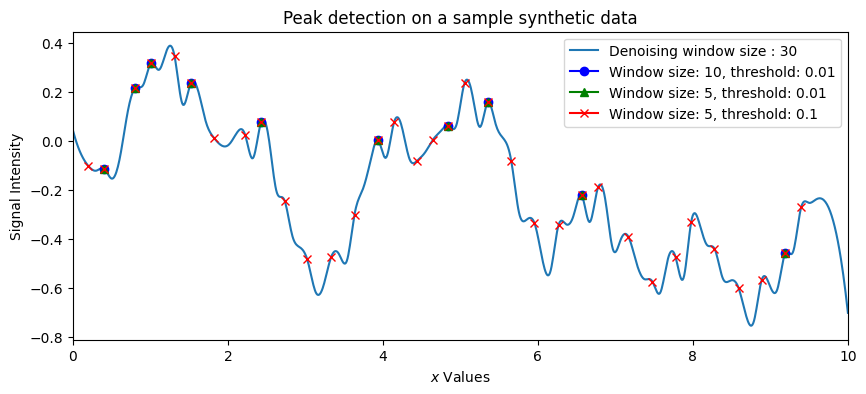

In [41]:
interpolated = Interpolate(x_values, synthetic_spectral_data, gratings=100, denoising_window_size=10)
interpolated.denoise_signal() # denoise the signal from the given parameters
interpolated = Interpolate(interpolated.x_val, interpolated.y_val)

peaks_5000 = find_peaks(interpolated, window_size=10)
peaks_1000 = find_peaks(interpolated, window_size=5)
peaks_3    = find_peaks(interpolated, window_size=5, threshold=0.1)


plt.figure(figsize=(10, 4))
plt.plot(interpolated.x_val, interpolated.y_val, label='Denoising window size : 30')

count = 0
for p in peaks_5000:
    if count == 0:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b',  marker ='o',label='Window size: 10, threshold: 0.01')
    else:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'b',  marker ='o')
    count += 1

count=0
for p in peaks_1000:
    if count == 0:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'g',  marker ='^', label='Window size: 5, threshold: 0.01')
    else:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'g',  marker ='^')
    count += 1

count=0
for p in peaks_3:
    if count == 0:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'r',  marker ='x', label='Window size: 5, threshold: 0.1')
    else:
        plt.plot(interpolated.x_val[p], interpolated.y_val[p], color = 'r',  marker ='x')
    count += 1
    
plt.title('Peak detection on a sample synthetic data')
plt.xlim([0,10])
plt.xlabel(r'$x$ Values')
plt.ylabel('Signal Intensity')
plt.legend()
plt.show()